<a href="https://colab.research.google.com/github/Viroslav/CV_final_task/blob/main/Final_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Your task is to find the shaded segmentation mask.
Check out the guidelines_of_first_20_images folder. This folder is to illustrate and guide you for better understanding on the problem. 

You have to write an algorithm that will solve the following problem. Here are the instructions for your algorithm.

Inputs for the algorithm are in the dataset folder:
1. Image raw (the image folder)
2. Human parsing of the image 
3. Pose estimation of the person (both json and image) [*1]

Output:
1. The person's image with gray shaded region. Look at the sample_output.jpg for details.

Note: you don't have to use all the inputs given to you. You may use only those inputs that you find important for your algorithm to work better.



[*1]
body25 + hands labelling, check out the openpose labels for more details if you want.

## Mount Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
path = '/content/drive/MyDrive/Final_task/Task'

## imports

In [29]:
import torch
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from skimage.transform import rescale, ProjectiveTransform, warp
import pickle
import pandas as pd
import random
from skimage import io
from pylab import imshow

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


from matplotlib import cm
from skimage.feature import canny
import imutils
from sklearn.metrics import accuracy_score

import warnings
import os
import torch
warnings.filterwarnings(action='ignore', category=DeprecationWarning)



np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True


%matplotlib inline
from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Auxiliary Functions

In [55]:
def show(img, cmap=None):
    """
    function to plot image
    """
    
    plt.figure(figsize=(14,8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

## work with data

In [61]:
%%time
human_parsing = {}
for img in os.listdir(path + '/dataset/human_parsing/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        human_parsing[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/human_parsing/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(human_parsing)} photos of human_parsing completed')

All 704 photos of human_parsing completed
CPU times: user 4.43 s, sys: 611 ms, total: 5.05 s
Wall time: 6.45 s


In [63]:
%%time
image = {}
for img in os.listdir(path + '/dataset/image/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        image[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/image/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(image)} photos of image completed')

All 704 photos of image completed
CPU times: user 8.04 s, sys: 1.72 s, total: 9.76 s
Wall time: 17.9 s


In [66]:
%%time
pose_jpg = {}
for img in os.listdir(path + '/dataset/pose_img/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        pose_jpg[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/pose_img/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(pose_jpg)} photos of pose_jpg completed')

All 704 photos of pose_jpg completed
CPU times: user 7 s, sys: 1.48 s, total: 8.48 s
Wall time: 16.3 s


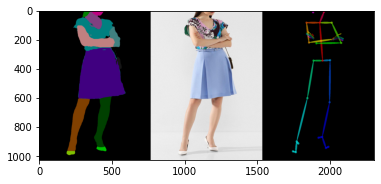

In [72]:
imshow(np.hstack([human_parsing['168762_00.png'], image['168762_00.jpg'], pose_jpg['168762_00_rendered.png']]))

## Thoughts


Dress size must be ankle length.